In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


# Import data

In [2]:
import pickle
import gdown

In [3]:
data_cleaned_url = "https://drive.google.com/uc?id=1-I5k-1NlFozfdbRb5JVy7nEfQEXqYP9c"
output = './Download/data_cleaned_gdown.zip'
gdown.download(data_cleaned_url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-I5k-1NlFozfdbRb5JVy7nEfQEXqYP9c
To: /home/anthony/Documents/Research-Mapping-Uncanny-Valley/Code/Download/data_cleaned_gdown.zip
786MB [00:14, 54.5MB/s] 


'./Download/data_cleaned_gdown.zip'

module zipfile does not support the compression format (I don't know why). 
You can use
```bash
sudo apt-get update
sudo apt-get install unzip
unzip ./Download/data_cleaned_gdown.zip
```
to unzip the file to `/Code/Download` directory

In [3]:
with open('./Download/data_cleaned.pickle', 'rb') as handle:
    data_cleaned = pickle.load(handle)

# Cosine similarity with emotions

In [5]:
from util import semantic_search
sents_emotion_vec = semantic_search(data_cleaned['RS_2020_nosleep']['selftext'][5], verbose = False)
sents_emotion_vec

array([[ 0.21698272,  0.20960012,  0.19537641, ..., -0.02441338,
        -0.0326806 , -0.06282185],
       [ 0.42663223,  0.37293845,  0.36481518, ...,  0.10002041,
         0.05779833,  0.03616553],
       [ 0.30050087,  0.21807092,  0.19975151, ...,  0.03358124,
        -0.00511191, -0.02358057],
       ...,
       [ 0.55303162,  0.49452001,  0.4796218 , ..., -0.03603059,
        -0.06295857, -0.07457595],
       [ 0.26004642,  0.24877664,  0.22177438, ..., -0.0289279 ,
        -0.04870765, -0.09610555],
       [ 0.23916952,  0.2003721 ,  0.14978789, ..., -0.09678131,
        -0.12432525, -0.17019036]])

In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sents_emotion_vec = scaler.fit_transform(sents_emotion_vec)

In [7]:
scaled_sents_emotion_vec

array([[-0.58307311, -0.54791709, -0.54447741, ..., -0.20292152,
        -0.092175  , -0.13933973],
       [-0.02789105, -0.11317501, -0.09906804, ...,  0.39033676,
         0.33625014,  0.30587438],
       [-0.36190504, -0.52537116, -0.53297644, ...,  0.07357725,
         0.038365  ,  0.03715519],
       ...,
       [ 0.30683274,  0.21042704,  0.20272799, ..., -0.25830845,
        -0.23554366, -0.19220596],
       [-0.46903424, -0.44364467, -0.47508417, ..., -0.22444521,
        -0.16806437, -0.28903936],
       [-0.52431927, -0.57247844, -0.66431749, ..., -0.54794736,
        -0.52611991, -0.62224954]])

# Construct E, S matrices

## Idea: maybe a custom layer in the end before the last layer.

For each sentence in a document, we have a (1,768) sentence embeddings. Combining all sentence embeddings, we have a matrix S of dimension (N,768)

$$
S = 
\begin{bmatrix}
    s_{1,1} & s_{1,2} & s_{1,3} & \dots  & s_{1,d} \\
    s_{2,1} & s_{2,2} & s_{2,3} & \dots  & s_{2,d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    s_{N,1} & s_{N,2} & s_{N,3} & \dots  & s_{N,d}
\end{bmatrix} \\
\text{where d is the embedding dimension (in this case, 768) and N is number of sentences in a document}
$$

Based on these embeddings, we can get the emotional scores by calculating the cosine similarity between each motion and a sentence. We can conbine these scores into another matrix E. E has dimension of (27,N)

$$
E = 
\begin{bmatrix}
    e_{1,1} & e_{2,1} & e_{3,1} & \dots  & e_{N,1} \\
    e_{1,2} & e_{2,2} & e_{3,2} & \dots  & e_{N,2} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    e_{1,27} & e_{2,27} & e_{3,27} & \dots  & e_{N,27}
\end{bmatrix} \\
\text{where N is number of sentences in a document}
$$

Natually, we want to have the same dimension for each post (document). So, we can multiply these two matrices together: 

$$E\times S$$
$$(27,N) \times (N,768) = (27,768)$$

Then we will have the same dimension for each post.

In [8]:
from IPythonfeature_dfslay import display
from util import semantic_search
from sentence_transformers import SentenceTransformer
import spacy
nlp = spacy.load('en_core_web_lg')
import swifter
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def apply_semantic_search(row):
    E = semantic_search(row['selftext'], verbose = False)
    return np.transpose(E)

def apply_scaled_E(row):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(row['E'])

def apply_SBERT(row):
    model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

    doc = nlp(row['selftext'])
    #Our sentences we like to encode
    sentences = [repr(sent) for sent in doc.sents]

    #Sentences are encoded by calling model.encode()
    S = model.encode(sentences)
    return S

feature_dfs = dict()

for key, df in data_cleaned.items():
    if not key.endswith('comments'):
        if key.endswith(('self','nosleep')):
            print("\n\n======================\n")
            print("Dataset:", key)
            print("\nCalculating...")
            df_new = df.head(1000).copy()
            df_new['E'] = df_new.swifter.progress_bar(enable=True, desc="Calculating Emotion Matrix E").apply(apply_semantic_search, axis=1)
            df_new['scaled_E'] = df_new.swifter.progress_bar(enable=True, desc="Scaling E").apply(apply_scaled_E, axis=1)
            df_new['S'] = df_new.swifter.progress_bar(enable=True, desc="Calculating SBERT embeddings S").apply(apply_SBERT, axis=1)
            df_new['scaled_E*S'] = df_new.swifter.progress_bar(enable=True, desc="Calculating multiplication of scaled E and S").apply(lambda x: np.matmul(x['scaled_E'], x['S']), axis=1)
            
            feature_dfs[key] = df_new




Dataset: RS_2020_nosleep

Calculating...






Dataset: RS_2020_self

Calculating...


In [9]:
pickle.dump(feature_dfs, open("./Download/feature_dfs.pickle", "wb" ))

## Re-import featue_dfs

In [26]:
with open('./Download/feature_dfs.pickle', 'rb') as handle:
    feature_dfs = pickle.load(handle)

## Pre-processing

Extract features

In [31]:
non_creepy_features = np.array(feature_dfs['RS_2020_self']['scaled_E*S'].to_list())
creepy_features = np.array(feature_dfs['RS_2020_nosleep']['scaled_E*S'].to_list())

features = np.concatenate((creepy_features, non_creepy_features))
labels = np.concatenate((np.zeros(len(non_creepy_features)), np.ones(len(creepy_features))))

Show shapes

In [33]:
print(features.shape)
print(labels.shape)

(2000, 27, 768)
(2000,)


Shuffle the features and labels correspondingly

In [51]:
from sklearn.utils import shuffle

features, labels = shuffle(features, labels)
print(labels)

[1. 1. 1. ... 1. 0. 0.]


Scale to 0 to 1

In [52]:
# flatten each matrix
features.reshape((features.shape[0],features.shape[1]*features.shape[2]))
features.shape

(2000, 27, 768)

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features.reshape((features.shape[0],features.shape[1]*features.shape[2])))
scaled_features = scaled_features.reshape(features.shape)
print(scaled_features, labels)

[[[0.59345985 0.3588411  0.11536062 ... 0.48649159 0.72945515 0.51658735]
  [0.58991645 0.40486651 0.09210209 ... 0.4807704  0.73828055 0.51701695]
  [0.56836426 0.37029778 0.04639268 ... 0.47304686 0.7465258  0.48780608]
  ...
  [0.38347799 0.62341635 0.85331821 ... 0.516262   0.29008619 0.43205983]
  [0.3820513  0.66644165 0.86990313 ... 0.514917   0.25028084 0.43732169]
  [0.40654015 0.6411589  0.88463938 ... 0.51350841 0.27054485 0.48341265]]

 [[0.56967154 0.36566652 0.14307911 ... 0.51601968 0.69547726 0.50617166]
  [0.56658306 0.41634796 0.12549715 ... 0.5093266  0.70411305 0.50863007]
  [0.54730556 0.37976092 0.08124663 ... 0.49850657 0.71915803 0.48281625]
  ...
  [0.40626285 0.61578989 0.83402833 ... 0.49330352 0.3239246  0.44429007]
  [0.40545094 0.65950012 0.84874162 ... 0.49169395 0.28193262 0.44755589]
  [0.43032846 0.63433348 0.85692089 ... 0.48398032 0.30452274 0.49382834]]

 [[0.58821783 0.3618635  0.11713574 ... 0.48067929 0.72311369 0.51202072]
  [0.58319217 0.410949

Split the data

- [ ] 70% train, 15% val, 15% test
- [x] 80% train, 10% val, 10% test
- [ ] 60% train, 20% val, 20% test

In [63]:
from sklearn.model_selection import train_test_split

X = scaled_features.reshape(-1, 27, 768, 1)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

# Recall: our best "hand-tuned" model

```python
model = keras.Sequential([
    keras.layers.Dense(units = 303, input_shape = (769,), activation = 'relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units = 128, activation = 'relu'),
    keras.layers.Dense(units = 64, activation = 'relu'),
    keras.layers.Dense(units = 32, activation = 'relu'),
    keras.layers.Dense(units = 16, activation = 'relu'),
    keras.layers.Dense(units = 1, activation = 'sigmoid')
])
```

## Model here

In [65]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [67]:
model = Sequential([
    Conv2D(64, (2,2), input_shape = X.shape[1:], activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (2,2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.1),
    
    Dense(units = 1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
             optimizer = "Adam", # you can tune the learning rate here. Default lr = 0.01
             metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 30, batch_size = 32)

Epoch 1/30
50/50 [==============================] - 1s 17ms/step - loss: 0.5831 - accuracy: 0.7144 - val_loss: 0.2582 - val_accuracy: 0.9200
Epoch 2/30
50/50 [==============================] - 1s 15ms/step - loss: 0.3097 - accuracy: 0.8794 - val_loss: 0.1904 - val_accuracy: 0.9200
Epoch 3/30
50/50 [==============================] - 1s 15ms/step - loss: 0.2462 - accuracy: 0.9156 - val_loss: 0.1804 - val_accuracy: 0.9450
Epoch 4/30
50/50 [==============================] - 1s 15ms/step - loss: 0.2091 - accuracy: 0.9281 - val_loss: 0.1423 - val_accuracy: 0.9600
Epoch 5/30
50/50 [==============================] - 1s 15ms/step - loss: 0.2082 - accuracy: 0.9294 - val_loss: 0.1476 - val_accuracy: 0.9650
Epoch 6/30
50/50 [==============================] - 1s 15ms/step - loss: 0.1986 - accuracy: 0.9300 - val_loss: 0.1081 - val_accuracy: 0.9750
Epoch 7/30
50/50 [==============================] - 1s 15ms/step - loss: 0.1605 - accuracy: 0.9450 - val_loss: 0.0953 - val_accuracy: 0.9700
Epoch 8/30
50

In [70]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 5ms/step - loss: 0.0372 - accuracy: 0.9750


[0.03715205565094948, 0.9750000238418579]

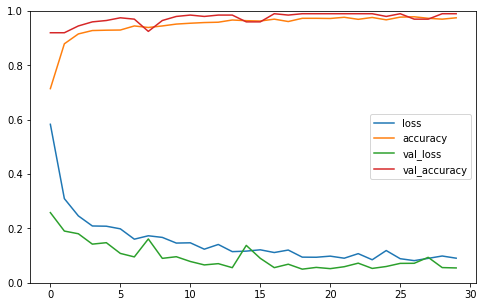

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid = True
plt.gca().set_ylim(0,1)
plt.show()